In [ ]:
import duckdb

import mplsoccer
from mplsoccer import Pitch, VerticalPitch

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

In [ ]:
df_stories = duckdb.sql(f"""
    SELECT * FROM '/content/drive/MyDrive/footly_data/stories.parquet'
    WHERE type = 'pass'
""").df()

df_stories.head(3)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,player_position,throw_in,start_x,penalty_conceded_goal,penalty_foul,lateral_pass,own_goal,linkup_play,type,red_card,...,shot_goal_zone,conceded_goal,is_pass,possession_attack,pass_blocked,opportunity,possession_id,shot_id,possession_set_piece_attack,__index_level_0__
0,AMF,False,49,False,False,False,False,False,pass,False,...,None,False,True,True,False,False,1296149340,0,False,0
1,CF,False,27,False,False,False,False,False,pass,False,...,None,False,True,True,False,False,1296149340,0,False,1
2,RCB,False,57,False,False,False,False,False,pass,False,...,None,False,True,True,False,False,1296149340,0,False,3


In [ ]:
# List of columns to check
columns_to_check = [
    'possession_free_kick', 'free_kick', 'free_kick_cross',
    'possession_free_kick_cross', 'possession_direct_free_kick',
    'possession_corner', 'corner', 'possession_set_piece_attack',
    'hand_pass'
]

# Filter out rows where any of the specified columns are True
df_stories_brez_prekinitev = df_stories[~df_stories[columns_to_check].any(axis=1)]

# Display the first few rows to verify
df_stories_brez_prekinitev.shape

(765496, 138)

In [ ]:
# List of columns to keep
columns_to_keep = [
    'id',
    'start_x',
    'start_y',
    'end_x',
    'end_y',
    'pass_length',
    'successful',
    'pass_high',
    'player_id',
    'team_id',
    'pass_recipient_id',
    'player_position',
    'season',
    'long_pass',
    'possession_id',
    'minute'
]

# Select only the desired columns
df_done = df_stories_brez_prekinitev[columns_to_keep]

# Display the first few rows to verify
df_done.head()

,id,start_x,start_y,end_x,end_y,pass_length,successful,pass_high,player_id,team_id,pass_recipient_id,player_position,season,long_pass,possession_id,minute
0,1296149340,49,50,27,44,23,True,False,302292,1609,346158,AMF,2021,False,1296149340,0
1,1296151267,27,44,64,68,42,False,True,346158,1609,-1,CF,2021,True,1296149340,0
2,1296149344,57,80,67,92,13,True,False,370224,1609,302292,RCB,2021,False,1296149340,0
3,1296149345,67,92,68,81,8,True,True,302292,1609,70389,AMF,2021,False,1296149340,0
22,1296149373,72,87,71,78,6,True,False,120339,1609,49876,RDMF,2021,False,1296149372,1


In [ ]:
# Create a copy and scale the coordinates to real pitch dimensions (105x68 meters)
df_done_copy = df_done.copy()
df_done_copy["start_x"] *= 105 / 100
df_done_copy["start_y"] *= 68 / 100
df_done_copy["end_x"] *= 105 / 100
df_done_copy["end_y"] *= 68 / 100

df_done_copy.head(3)

,id,start_x,start_y,end_x,end_y,pass_length,successful,pass_high,player_id,team_id,pass_recipient_id,player_position,season,long_pass,possession_id,minute
0,1296149340,51.45,34.00,28.35,29.92,23,True,False,302292,1609,346158,AMF,2021,False,1296149340,0
1,1296151267,28.35,29.92,67.20,46.24,42,False,True,346158,1609,-1,CF,2021,True,1296149340,0
2,1296149344,59.85,54.40,70.35,62.56,13,True,False,370224,1609,302292,RCB,2021,False,1296149340,0


In [ ]:
# Recalculate pass_length using scaled coordinates
df_done_copy["pass_length"] = np.sqrt(
    (df_done_copy["end_x"] - df_done_copy["start_x"])**2 +
    (df_done_copy["end_y"] - df_done_copy["start_y"])**2
)

df_done_copy.head(3)

,id,start_x,start_y,end_x,end_y,pass_length,successful,pass_high,player_id,team_id,pass_recipient_id,player_position,season,long_pass,possession_id,minute
0,1296149340,51.45,34.00,28.35,29.92,23.457545,True,False,302292,1609,346158,AMF,2021,False,1296149340,0
1,1296151267,28.35,29.92,67.20,46.24,42.138639,False,True,346158,1609,-1,CF,2021,True,1296149340,0
2,1296149344,59.85,54.40,70.35,62.56,13.297955,True,False,370224,1609,302292,RCB,2021,False,1296149340,0


In [ ]:
df_done_copy["angle"] = np.arctan2(df_done_copy["end_y"] - df_done_copy["start_y"], df_done_copy["end_x"] - df_done_copy["start_x"])
df_done_copy.head(3)

,id,start_x,start_y,end_x,end_y,pass_length,successful,pass_high,player_id,team_id,pass_recipient_id,player_position,season,long_pass,possession_id,minute,angle
0,1296149340,51.45,34.00,28.35,29.92,23.457545,True,False,302292,1609,346158,AMF,2021,False,1296149340,0,-2.966772
1,1296151267,28.35,29.92,67.20,46.24,42.138639,False,True,346158,1609,-1,CF,2021,True,1296149340,0,0.397694
2,1296149344,59.85,54.40,70.35,62.56,13.297955,True,False,370224,1609,302292,RCB,2021,False,1296149340,0,0.660647


In [ ]:
# Randomly sample 50% of the DataFrame
df_smaller = df_done_copy.sample(frac=0.5, random_state=123)

# Optionally, reset the index if needed
df_smaller.reset_index(drop=True, inplace=True)

print(f"Original size: {len(df_done_copy)}, Reduced size: {len(df_smaller)}")

Original size: 765496, Reduced size: 382748


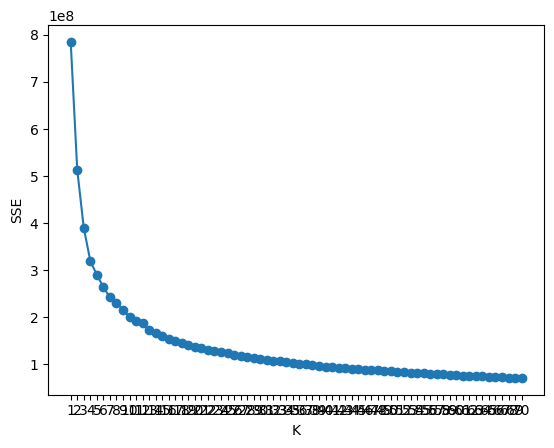

Text(0.5, 0, 'k')

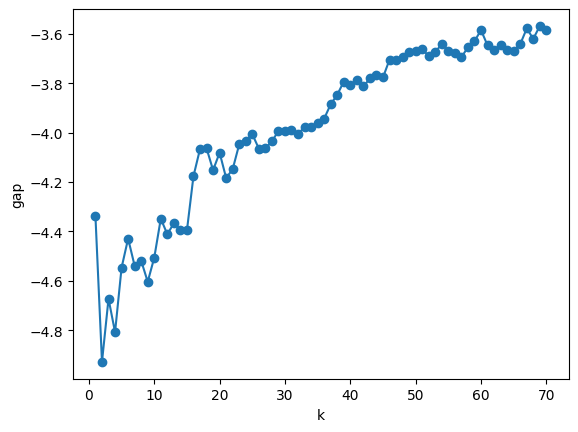

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin_min

K = np.linspace(1, 70, 70)
X = df_smaller[["start_x", "start_y", "end_x", "end_y", "angle", "pass_length"]].values
elbow = {"sse": [], "k": [], "sil": []}
for k in K:
    cluster = KMeans(n_clusters = int(k), random_state = 2147)
    labels = cluster.fit_predict(X)
    elbow["sse"].append(cluster.inertia_)
    elbow["k"].append(k)

plt.scatter(elbow["k"], elbow["sse"])
plt.plot(elbow["k"], elbow["sse"])
plt.xticks(np.linspace(1, 70, 70))
plt.xlabel("K")
plt.ylabel("SSE")
plt.show()
from sklearn.metrics import pairwise_distances
def compute_inertia(a, X, centers):
    _, distances = pairwise_distances_argmin_min(centers, X)
    return np.mean(distances)

def compute_gap(clustering, data, k_max, n_references=5):
    reference = np.random.rand(*data.shape)
    reference_inertia = []
    for k in range(1, k_max + 1):
        local_inertia = []
        for _ in range(n_references):
            clustering.n_clusters = k
            clustering.fit(reference)
            centers = clustering.cluster_centers_
            local_inertia.append(compute_inertia(clustering.labels_, reference, centers))
        reference_inertia.append(np.mean(local_inertia))

    ondata_inertia = []
    for k in range(1, k_max + 1):
        clustering.n_clusters = k
        clustering.fit(data)
        centers = clustering.cluster_centers_
        ondata_inertia.append(compute_inertia(clustering.labels_, data, centers))

    gap = np.log(reference_inertia) - np.log(ondata_inertia)
    return gap, np.log(reference_inertia), np.log(ondata_inertia)

k_max = 70
gap, reference_inertia, ondata_inertia = compute_gap(MiniBatchKMeans(random_state = 2147), X, k_max)

plt.plot(range(1, k_max+1), gap, '-o')
plt.ylabel('gap')
plt.xlabel('k')

FileNotFoundError: [Errno 2] No such file or directory: 'predstavitev/1_0/clusters_of_passes.png'

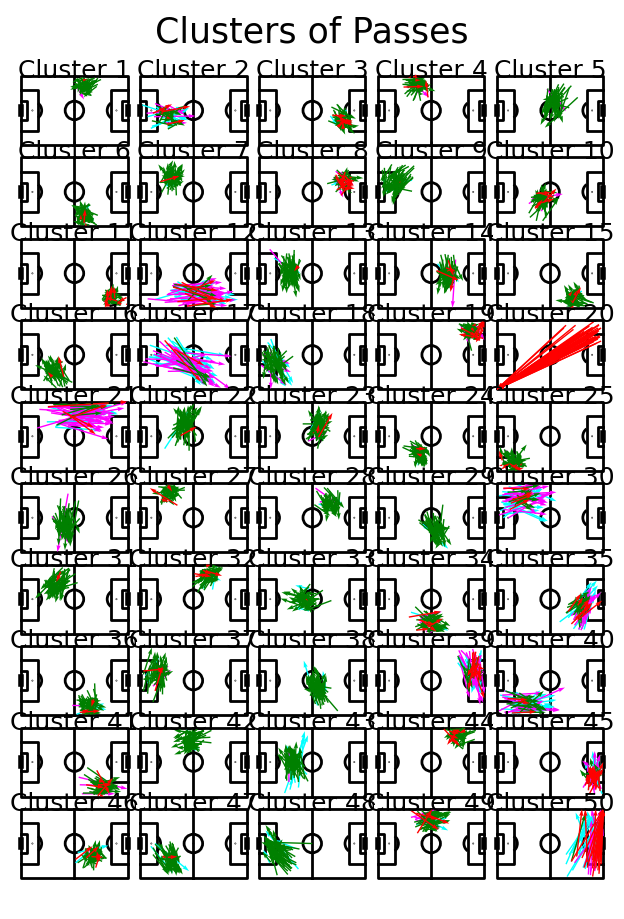

In [ ]:
from sklearn.cluster import KMeans
# Perform clustering
k = 60  # Number of clusters determined by Gap Statistic
cluster = KMeans(n_clusters=k, random_state=2147)
labels = cluster.fit_predict(df_smaller[["start_x", "start_y", "end_x", "end_y", "angle"]].values)

# Add cluster labels to the dataframe
df_smaller["label"] = labels

# Set up the pitch
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=5, nrows=12, grid_width=0.95, grid_height=0.9, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Maximum number of passes to display per cluster
max_passes = 50

# Plot each cluster on a separate pitch
for clust, ax in zip(range(k), axs['pitch'].flat[:k]):
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {clust + 1}",
            ha='center', va='center', fontsize=18)

    # Filter passes belonging to the current cluster
    clustered = df_smaller[df_smaller["label"] == clust]

    # Limit the number of passes displayed
    if len(clustered) > max_passes:
        clustered = clustered.sample(n=max_passes, random_state=2147)

    # Separate passes by success and pass_high
    successful_high = clustered[(clustered["successful"]) & (clustered["pass_high"])]
    unsuccessful_high = clustered[(~clustered["successful"]) & (clustered["pass_high"])]
    successful_low = clustered[(clustered["successful"]) & (~clustered["pass_high"])]
    unsuccessful_low = clustered[(~clustered["successful"]) & (~clustered["pass_high"])]

    # Plot successful high passes (cyan)
    pitch.arrows(
        successful_high["start_x"], successful_high["start_y"],
        successful_high["end_x"], successful_high["end_y"],
        color="cyan", ax=ax, width=1, label="Successful (High)"
    )

    # Plot unsuccessful high passes (magenta)
    pitch.arrows(
        unsuccessful_high["start_x"], unsuccessful_high["start_y"],
        unsuccessful_high["end_x"], unsuccessful_high["end_y"],
        color="magenta", ax=ax, width=1, label="Unsuccessful (High)"
    )

    # Plot successful low passes (green)
    pitch.arrows(
        successful_low["start_x"], successful_low["start_y"],
        successful_low["end_x"], successful_low["end_y"],
        color="green", ax=ax, width=1, label="Successful (Low)"
    )

    # Plot unsuccessful low passes (red)
    pitch.arrows(
        unsuccessful_low["start_x"], unsuccessful_low["start_y"],
        unsuccessful_low["end_x"], unsuccessful_low["end_y"],
        color="red", ax=ax, width=1, label="Unsuccessful (Low)"
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Clusters of Passes', ha='center', va='center', fontsize=25)
# Save the plot to a file
plt.savefig("predstavitev/1_0/clusters_of_passes.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
df_smaller.tail()

,id,start_x,start_y,end_x,end_y,pass_length,successful,pass_high,player_id,team_id,pass_recipient_id,player_position,season,long_pass,possession_id,minute,angle,label
382743,1551575862,5.25,33.32,19.95,63.92,33.947754,True,False,227085,1629,8360,GK,2022,False,1551578130,85,1.122958,36
382744,1569707481,63.00,57.12,73.50,64.60,12.891873,True,False,275780,1616,1712,RDMF,2022,False,1569707460,12,0.618987,31
382745,2116412058,56.70,23.80,92.40,21.08,35.803469,True,False,237269,1616,-1,LDMF,2023,False,2116412048,18,-0.076044,2
382746,2183117372,77.70,23.12,80.85,13.60,10.027607,True,False,8981,1628,487034,LCMF,2023,False,2183117366,31,-1.251253,2
382747,1714718954,78.75,48.96,73.50,45.56,6.254798,True,False,477082,1624,413582,RB,2023,False,1714718943,63,-2.566893,27


In [ ]:
import pyarrow
import fastparquet

In [ ]:
# Save the reduced DataFrame as Parquet
df_smaller.to_parquet('/content/drive/MyDrive/footly_data/ALL_clustered_passes_1_colab.parquet', index=False)

print("DataFrame saved successfully!")

DataFrame saved successfully!


In [ ]:
df_smaller.to_csv("/content/drive/MyDrive/footly_data/ALL_clustered_passes_1_colab.csv", index=False)

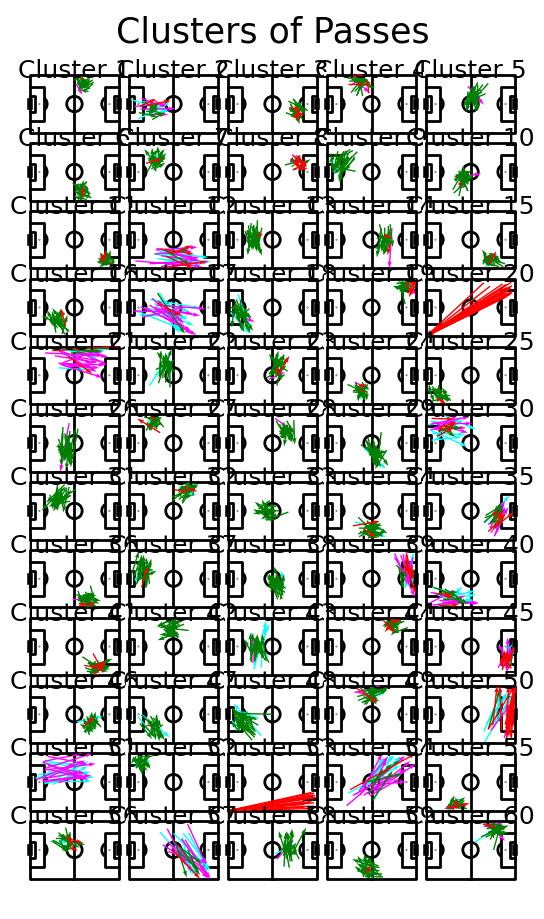

In [ ]:
# Set up the pitch
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=5, nrows=12, grid_width=0.95, grid_height=0.9, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Maximum number of passes to display per cluster
max_passes = 25

# Plot each cluster on a separate pitch
for clust, ax in zip(range(k), axs['pitch'].flat[:k]):
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {clust + 1}",
            ha='center', va='center', fontsize=18)

    # Filter passes belonging to the current cluster
    clustered = df_smaller[df_smaller["label"] == clust]

    # Limit the number of passes displayed
    if len(clustered) > max_passes:
        clustered = clustered.sample(n=max_passes, random_state=2147)

    # Separate passes by success and pass_high
    successful_high = clustered[(clustered["successful"]) & (clustered["pass_high"])]
    unsuccessful_high = clustered[(~clustered["successful"]) & (clustered["pass_high"])]
    successful_low = clustered[(clustered["successful"]) & (~clustered["pass_high"])]
    unsuccessful_low = clustered[(~clustered["successful"]) & (~clustered["pass_high"])]

    # Plot successful high passes (cyan)
    pitch.arrows(
        successful_high["start_x"], successful_high["start_y"],
        successful_high["end_x"], successful_high["end_y"],
        color="cyan", ax=ax, width=1, label="Successful (High)"
    )

    # Plot unsuccessful high passes (magenta)
    pitch.arrows(
        unsuccessful_high["start_x"], unsuccessful_high["start_y"],
        unsuccessful_high["end_x"], unsuccessful_high["end_y"],
        color="magenta", ax=ax, width=1, label="Unsuccessful (High)"
    )

    # Plot successful low passes (green)
    pitch.arrows(
        successful_low["start_x"], successful_low["start_y"],
        successful_low["end_x"], successful_low["end_y"],
        color="green", ax=ax, width=1, label="Successful (Low)"
    )

    # Plot unsuccessful low passes (red)
    pitch.arrows(
        unsuccessful_low["start_x"], unsuccessful_low["start_y"],
        unsuccessful_low["end_x"], unsuccessful_low["end_y"],
        color="red", ax=ax, width=1, label="Unsuccessful (Low)"
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Clusters of Passes', ha='center', va='center', fontsize=25)
# Save the plot to a file
plt.savefig("/content/drive/MyDrive/footly_data/clusters_of_passes_2.png", dpi=300, bbox_inches="tight")
plt.show()

# Test

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/footly_data/ALL_clustered_passes_1_colab.csv")
df.head()

,id,start_x,start_y,end_x,end_y,pass_length,successful,pass_high,player_id,team_id,pass_recipient_id,player_position,season,long_pass,possession_id,minute,angle,label
0,2191808088,37.80,64.60,49.35,66.64,11.728772,True,False,607944,1624,524163,CF,2023,False,2191808080,19,0.174820,3
1,1928974561,28.35,26.52,25.20,12.92,13.960032,True,False,404216,1614,5910,RCMF,2023,False,1928973430,51,-1.798401,46
2,1372062809,64.05,7.48,57.75,12.24,7.896050,False,False,8221,1628,-1,LB,2022,False,1372063371,14,2.494545,5
3,1720062900,63.00,46.92,56.70,42.84,7.505758,True,False,11066,1610,20394,RWF,2023,False,1720062894,52,-2.566893,4
4,1863793552,78.75,48.28,84.00,53.72,7.560165,True,False,470978,1624,472363,RCMF,2023,False,1863793547,90,0.803170,59


In [ ]:
df["label"].value_counts()

,count
label,
35,10613
31,10091
3,9868
0,9481
43,9273
5,9265
54,8997
14,8872
15,8451


In [ ]:
df_arsenal = df[df["team_id"] == 1609]

In [ ]:
df_arsenal["label"].value_counts().head(6)

,count
label,
31,715
43,713
27,650
59,570
14,557
35,552
